<a href="https://colab.research.google.com/github/Nova3012k/Regression-Methods-Machine-Learning-/blob/main/Clasificacion_con_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificacion con KNN

## Fundamentos de la técnica

El algoritmo K-Nearest Neighbors (KNN) o "K-Vecinos Más Cercanos" es un método de aprendizaje supervisado basado en instancias.Se le clasifica como un algoritmo de "Aprendizaje Perezoso" (Lazy Learning).

Esto significa que el algoritmo no "entrena" generando un modelo general o una ecuación compleja durante la fase de aprendizaje. En su lugar, simplemente memoriza los datos de entrenamiento tal cual son.

¿Cómo funciona la clasificación? El principio es intuitivo: "Las cosas similares suelen estar cerca unas de otras".

1. Cuando llega un dato nuevo (una flor desconocida), el algoritmo calcula su distancia respecto a todos los datos memorizados.

2. Identifica los $K$ puntos más cercanos (los "vecinos").

3. Realiza una votación por mayoría: la clase (especie) más común entre esos vecinos se asigna al dato nuevo.

## Modelo Matemático

El funcionamiento de KNN se basa puramente en la geometría y el cálculo de distancias en un espacio multidimensional.
1. La Distancia Euclidiana

Para determinar qué tan "cerca" está una flor de otra, el algoritmo utiliza métricas de distancia. La más común es la Distancia Euclidiana, que es una generalización del Teorema de Pitágoras:$$d(p, q) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + ... + (q_n - p_n)^2}
$$Donde:
- $d$: Es la distancia calculada.
- $p$: Es el nuevo punto a clasificar (sus medidas de pétalos/sépalos).
- $q$: Es un punto existente en la base de datos.
- $n$: Es el número de características (dimensiones).

2. El Hiperparámetro "K"

El valor de $K$ representa el número de vecinos que tienen derecho a voto.

- Si $K$ es pequeño (ej. $K=1$): El modelo es muy sensible al "ruido". Si el punto más cercano es una anomalía, la clasificación será incorrecta (riesgo de Overfitting).

- Si $K$ es grande: El modelo se vuelve más robusto pero puede perder detalles finos de las fronteras entre clases (riesgo de Underfitting).

## Descripción de la librería y clases (Python)
Para este ejercicio utilizaremos la librería Scikit-Learn, que contiene todas las herramientas necesarias para el cálculo de distancias y clasificación.Las principales clases y funciones que utilizaremos son:

- sklearn.neighbors.KNeighborsClassifier:Es la clase principal que contiene el algoritmo KNN.n_neighbors: Es el parámetro más importante. Aquí definimos el valor de $K$ (cuántos vecinos votarán).

- metric: Define cómo se mide la distancia entre puntos. Por defecto utiliza la distancia de Minkowski con $p=2$, que equivale a la Distancia Euclidiana.

- sklearn.preprocessing.StandardScaler:Herramienta de preprocesamiento obligatoria para KNN.Se encarga de transformar todas las medidas (cm de pétalos y sépalos) para que tengan la misma escala (media 0 y desviación 1). Sin esto, las variables con números más grandes dominarían el cálculo de la distancia, haciendo que el modelo falle.

- sklearn.model_selection.train_test_split:Función que divide nuestro conjunto de 150 flores en dos grupos:Entrenamiento: Los datos que el modelo memorizará.Prueba: Los datos nuevos que usaremos para evaluar si clasifica bien.

- sklearn.metrics.classification_report:Genera un reporte completo con las métricas de evaluación (Precision, Recall y F1-Score) desglosadas para cada una de las 3 especies: Setosa, Versicolor y Virginica.

Interpretación de la GráficaUna vez generada la gráfica, debemos elegir el valor de $K$.

- Eje Y (Error): Buscamos que sea lo más bajo posible.

- Eje X (K): Buscamos un valor equilibrado.

- Si elegimos un $K$ muy bajo (ej. 1), el error suele ser bajo pero el modelo es inestable.

Observando la gráfica resultante, seleccionaremos el valor donde la curva se "estabiliza" o toca el suelo (generalmente K=3 o K=5 para este dataset). Ese será el valor que usaremos en la siguiente etapa para el entrenamiento final.

## Feature Engineering (Preparación de Variables)

En esta etapa preparamos los datos para maximizar el rendimiento del algoritmo.

- Escalamiento (Normalización): Esta es la parte crítica.

- El Problema: KNN clasifica calculando distancias físicas. Si una característica tiene magnitudes grandes y otra pequeñas, la distancia será dictada solo por la variable grande.

- La Solución: Usaremos StandardScaler. Al estandarizar los datos, aseguramos que el largo del sépalo, el ancho del pétalo, etc., contribuyan equitativamente a la decisión de qué flor se parece a cuál.

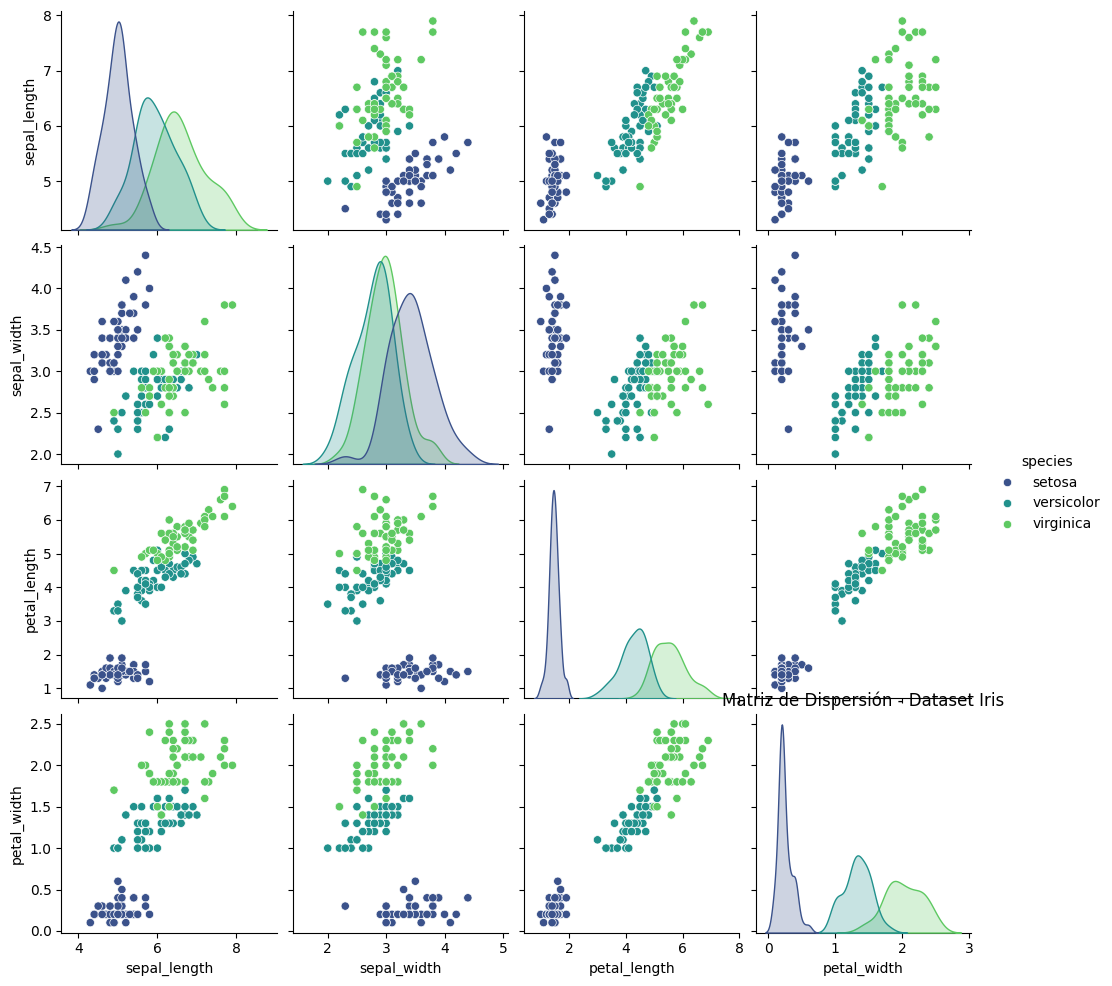

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargamos el dataset Iris (ya viene incluido en seaborn)
iris = sns.load_dataset('iris')

# 2. Creamos la Matriz de Dispersión (Pairplot)
# hue='species': Colorea los puntos según su especie (Setosa, Versicolor, Virginica)
# palette='viridis': Usa colores profesionales y fáciles de distinguir
sns.pairplot(iris, hue='species', palette='viridis')

# 3. Mostramos el gráfico
plt.title("Matriz de Dispersión - Dataset Iris") # Título opcional para la ventana
plt.show()

## Pipeline

Como no sabemos cuál es el mejor número de vecinos ($K$) para este dataset específico, usaremos el Método del Codo. Probaremos valores de $K$ del 1 al 20 y graficaremos el error para tomar una decisión informada.

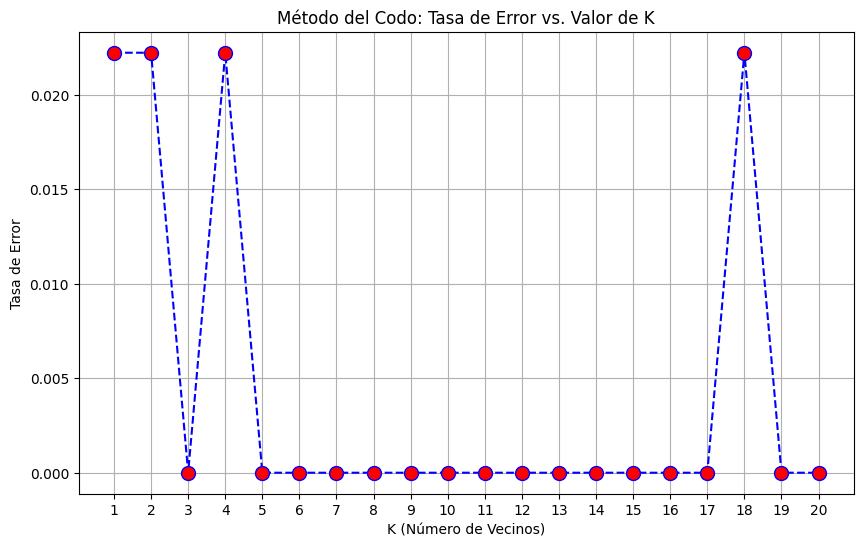

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Carga del Dataset Iris
iris = load_iris()
X = iris.data  # Características
y = iris.target # Etiquetas: 0=Setosa, 1=Versicolor, 2=Virginica

# 2. División de Datos (70% Train, 30% Test)
# SKLEARN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Escalamiento (OBLIGATORIO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- BÚSQUEDA DEL MEJOR K (MÉTODO DEL CODO) ---
tasas_error = []
rango_k = range(1, 21) # Probaremos K de 1 a 20

for i in rango_k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # Guardamos la tasa de error promedio
    tasas_error.append(np.mean(pred_i != y_test))

# Gráfico del Codo
plt.figure(figsize=(10,6))
plt.plot(rango_k, tasas_error, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Método del Codo: Tasa de Error vs. Valor de K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('Tasa de Error')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

Interpretación: Observando la gráfica generada arriba, seleccionamos el valor de $K$ donde el error sea bajo y estable (generalmente K=3 es ideal para Iris).

## Definición de Métricas de Evaluación

Para entender si nuestro modelo es bueno clasificando flores, no basta con "ver" la matriz. Necesitamos números concretos. A continuación definimos las 4 métricas principales utilizadas en el reporte.

1. Accuracy (Exactitud Global)Es la métrica más intuitiva. Responde a la pregunta: ¿Del total de flores, cuántas clasificó bien el modelo?Se calcula sumando todos los aciertos (la diagonal principal de la matriz) y dividiéndolos por el total de datos.$$Accuracy = \frac{\text{Total de Aciertos}}{\text{Total de Flores}}$$Interpretación: Si obtenemos 0.96, significa que el modelo tiene un 96% de éxito general.

2. Precision (Precisión)Esta métrica se calcula por cada especie. Responde a: "De todas las veces que el modelo dijo 'Esto es una Versicolor', ¿cuántas veces tenía razón?"Nos habla de la calidad de la predicción positiva.$$Precision = \frac{TP}{TP + FP}$$TP (Verdaderos Positivos): Versicolors clasificadas correctamente.FP (Falsos Positivos): Flores que NO eran Versicolor, pero el modelo dijo que sí.

3. Recall (Sensibilidad)También se calcula por cada especie. Responde a: "De todas las Versicolor que realmente existen en el campo, ¿cuántas fue capaz de encontrar el modelo?"Nos habla de la cantidad de aciertos sobre la realidad.$$Recall = \frac{TP}{TP + FN}$$FN (Falsos Negativos): Versicolors que el modelo ignoró o confundió con otra especie.

4. F1-ScoreEs el promedio armónico entre Precision y Recall. Es muy útil cuando queremos una sola métrica que resuma el equilibrio entre calidad (Precision) y cantidad (Recall).$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$


¿Cómo interpretar esto en el caso Iris?
Setosa: Generalmente tendrá Precision = 1.00 y Recall = 1.00. Es decir, el modelo es perfecto con esta flor.

Versicolor vs Virginica: Aquí es donde veremos variaciones.

Si el Precision de Virginica es bajo, significa que el modelo está etiquetando como "Virginica" a flores que en realidad son Versicolor (Falsos Positivos).

Si el Recall de Virginica es bajo, significa que el modelo está "perdiendo" Virginicas reales y clasificándolas como otra cosa.

## Entrenamiento Final y Evaluación

Con el valor de $K$ seleccionado (usaremos $K=3$), entrenamos el modelo final y evaluamos su desempeño.

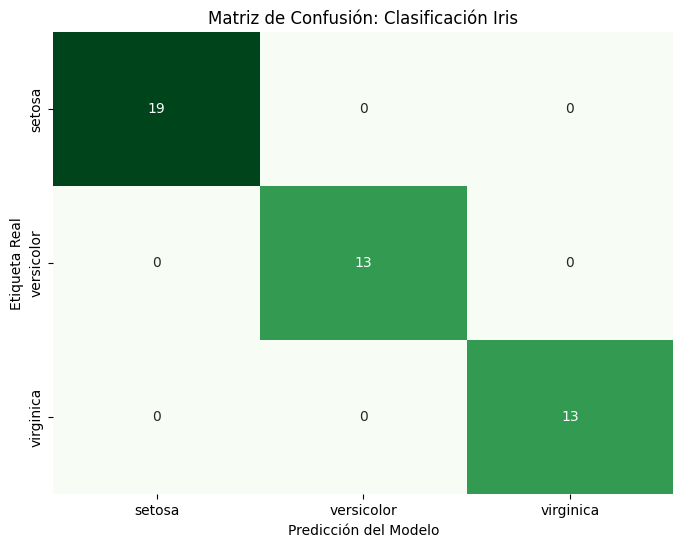

Accuracy del Modelo: 1.0000

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [ ]:
# 1. Entrenar el modelo con el K óptimo
knn_final = KNeighborsClassifier(n_neighbors=3)
knn_final.fit(X_train_scaled, y_train)

# 2. Predicciones
y_pred = knn_final.predict(X_test_scaled)

# 3. Visualización de la Matriz de Confusión
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Matriz de Confusión: Clasificación Iris')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()

# 4. Reporte de Métricas
print(f"Accuracy del Modelo: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Reporte de Clasificación Detallado ---")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

## Referencias Bibliográficas

Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of Eugenics, 7(2), 179–188.

Fix, E., & Hodges, J. L. (1951). Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties. USAF School of Aviation Medicine.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R. Springer.

Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.